In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

# Monte Carlo Reinforcement Learning

So far, we only considered planning, meaning that we assumed that we know the underlying model of the environment and that the agent has access to it. 
Now, we considere the case in which do not have access to the full MDP. That is, we do __model-free prediction__ now.

To illustrate this, we implement the black jack example from the RL Lecture 4 by Davin Silver for Monte Carlo Reinforcement Learning [see example](https://youtu.be/PnHCvfgC_ZA?t=1003)

We learn directly from episodes of experience. We do that by determining how much reward we get for a given policy. Policy can be just a random walk. 
That is, we execute some trajectories (action sequences) and then take the __mean reward__ of them.

Monte Carlo (MC) method properties:
* Learns from complete episodes (no bootstrapping)
* Uses the simplest idea that value=mean(return) of different samples
* Works only with episodic MDPs (all episodes must terminate)

For now, we do not care about the optimal policy but just about figuring out the value function.

Remember: $ G_t = R_{t+1} + \gamma R_{t+2} + ... + \sum_{k=0} \gamma^k \cdot R_{t+k+1}$

__Algorithm:__
* Update $V(s)$ incrementally after each episode
* For each state $S_t$ with return $G_t$ do:
    * $N(S_t) \gets N(S_t) +1$
    * $V(S_t) \gets V(S_t) + \frac{1}{N(S_t)} \cdot (G_t - V(S_t))$
        * Which corresponds to the _actual return_ ($G_t$) - the _estimated return_ ($V(S_t)$)
        * $\frac{1}{N(S_t)}$ is a weighting factor that let us forget old episodes slowly
        
__Important!!__ This algorithm just evaluates the value function for a given policy. It does __not__ return the optimal value function!!!

MC converges to solution with minimum mean squared error.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotting
plotting.set_layout(drawing_size=15)


## The Environment

For this example we use the python package [gym](https://gym.openai.com/docs/) which provides a ready-to-use implementation of a BlackJack environment.

The states are stored in this tuple format: \n(Agent's score , Dealer's visible score, and whether or not the agent has a usable ace)

Here, we can look at the number of different states:

In [4]:
import gym
env = gym.make('Blackjack-v0')
env.observation_space

Tuple(Discrete(32), Discrete(11), Discrete(2))

And the number of actions we can take:

In [5]:
env.action_space

Discrete(2)

To start a game call `env.reset()` which will return the obersavtion space

In [6]:
env.reset()

(18, 10, False)

We can take two different actions: `hit` = 1 or `stay` = 0. 

The result of this function call shows the _obersavtion space_, the reward (winning=+1, loosing =-1) and if the game is over, 

In [7]:
env.step(1)

((19, 10, False), 0.0, False, {})

## Define the Agent



In [8]:

class agents():
    """ This class defines the agent 
    """
    
    def __init__(self, state_space, action_space, gamma=1):
        """ TODO """ 
        
        # Store the discount factor 
        self.gamma = gamma
        
        n_player_states = state_space[0].n
        n_dealer_states = state_space[1].n
        n_usable_ace = state_space[0].n
        
        # two available actions stay (0) and hit (1)
        actions = range(action_space.n)
            
        # Store the value function for each state
        # start with zero
        self.v = np.zeros((n_player_states,n_dealer_states,n_usable_ace))
        
        # incremental counter for a state
        self.N = np.zeros((n_player_states,n_dealer_states,n_usable_ace))

    
    def random_move(self):
        # Do a random move, i.e. choose randomly 0 or 1
        return np.random.randint(0,2)
    
    
    def incre_counter(self, state):
        # Increments the counter for a given state
        
        # convert the true/false state to 0/1
        s2 = 1 if state[2] else 0
        # increment the counter for that state
        self.N[state[0],state[1],s2] += 1
    
    
    def policy_evaluation(self,all_states,all_rewards):
        # Update V(s) incrementally 
        for i_s,s in enumerate(all_states):

            # convert the true/false state to 0/1
            s2 = 1 if s[2] else 0
            # Get the value function for that state
            V_s = self.v[s[0],s[1],s2]
            # calculate the total reward
            G = np.sum([agent.gamma**k * r for k,r in enumerate(all_rewards)])
            # Update the value funtion
            self.v[s[0],s[1],s2] = V_s + 1/self.N[s[0],s[1],s2] * (G - V_s)

In [38]:
# how many episodes should be played
n_episodes = 50000
# initialize the agent. let it know the number of states and actions
agent = agents(env.observation_space, env.action_space)

# Incremental MC updates
# Play one episode then update V(s)
for i in range(n_episodes):
    all_states = []
    all_rewards = []
    
    # start the game
    s = env.reset()
    # save initiale states and update counter
    all_states.append(s)
    agent.incre_counter(s)

    # play until environment tells you that the game is over
    game_ended = False
    while not game_ended:
        # increment counter
        
        # End the game if sum of cards is >20
        if s[0] >= 20:
            move = 0
        else: 
            # otherwise do a random move. that should speed up the learning process
            move = 1 
        s,r,game_ended,_ = env.step(move)
    
        # save everything
        all_states.append(s)
        all_rewards.append(r)
        # increment the counter for a given state
        agent.incre_counter(s)

        
    ### END OF EPISODE ###
    # do the policy evaluation
    agent.policy_evaluation(all_states,all_rewards)
    



## Plotting

<ipython-input-39-a81e167e6988>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(range(13,22))
<ipython-input-39-a81e167e6988>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(range(1,11,2))
<ipython-input-39-a81e167e6988>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(range(13,22))
<ipython-input-39-a81e167e6988>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(range(1,11,2))


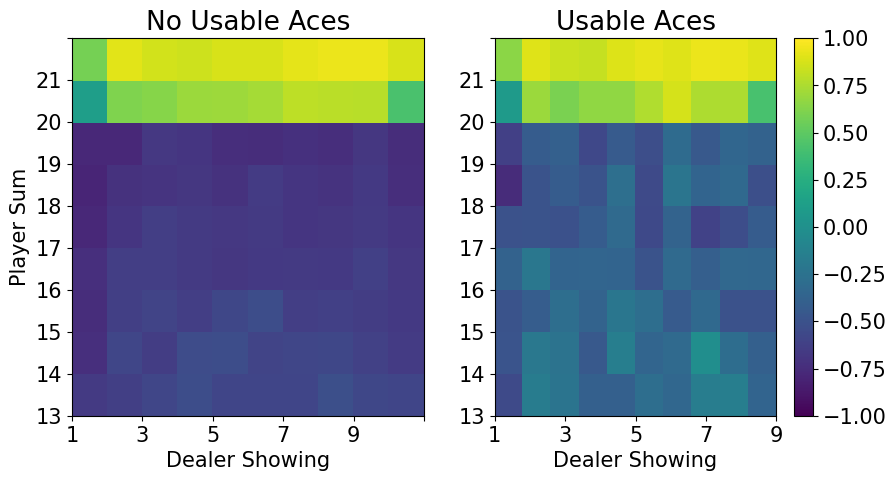

In [39]:
fig = plt.figure(figsize=(10,5))

axes = fig.subplots(1,2,squeeze=False)

ax = axes[0,0]


c = ax.pcolormesh(agent.v[13:22,1:,0],vmin=-1,vmax=1)
ax.set_yticklabels(range(13,22))
ax.set_xticklabels(range(1,11,2))
ax.set_xlabel('Dealer Showing')
ax.set_ylabel('Player Sum')
ax.set_title('No Usable Aces')
# plt.colorbar(c)

ax = axes[0,1]
c = ax.pcolormesh(agent.v[13:22,1:,1],vmin=-1,vmax=1)
ax.set_yticklabels(range(13,22))
ax.set_xticklabels(range(1,11,2))
ax.set_title('Usable Aces')
ax.set_xlabel('Dealer Showing')
plt.colorbar(c)

plt.show()

